In [2]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, Input, MaxPooling2D, BatchNormalization
from tensorflow.keras import Model
from time import time

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

# Set the seeds for reproducibility
from numpy.random import seed
from tensorflow.random import set_seed
seed_value = 1234578790
seed(seed_value)
set_seed(seed_value)


In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Dataset params
num_classes = 10
size = x_train.shape[1]

print('Train set:   ', len(y_train), 'samples')
print('Test set:    ', len(y_test), 'samples')
print('Sample dims: ', x_train.shape)


Train set:    60000 samples
Test set:     10000 samples
Sample dims:  (60000, 28, 28)


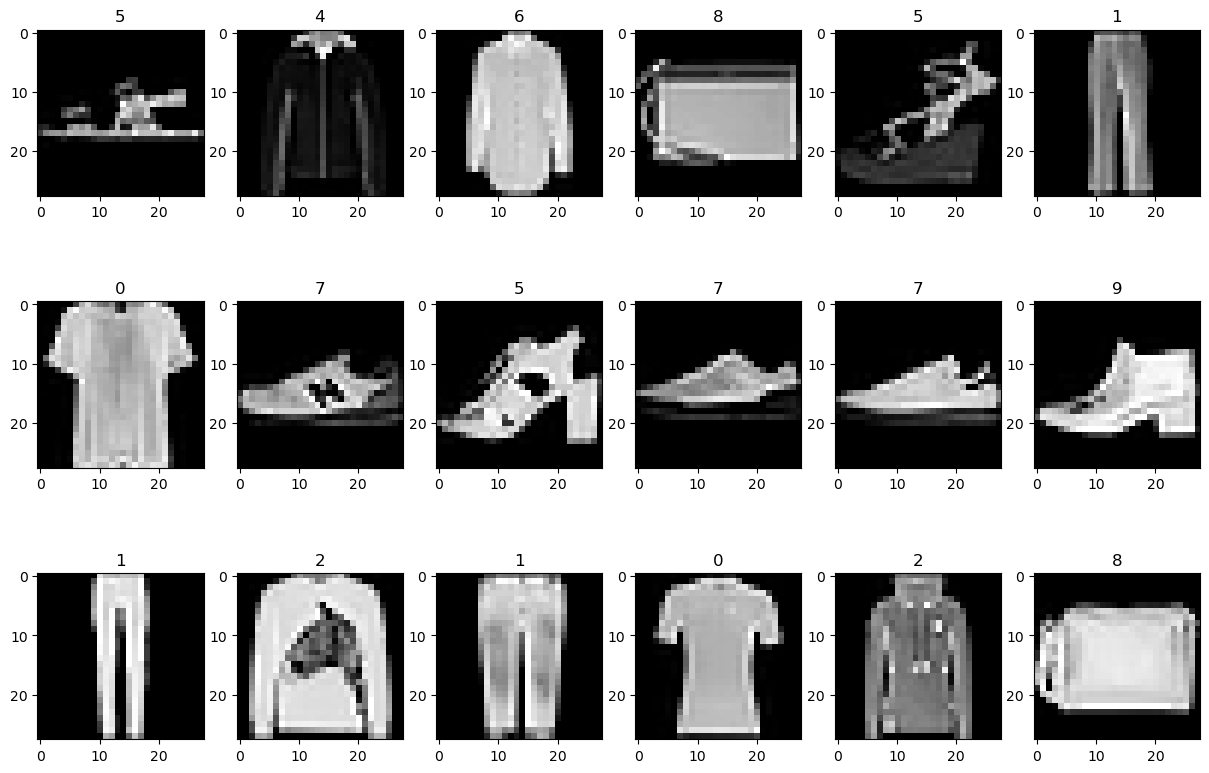

In [32]:
#Draw random samples
cnt = 1
for r in range(3):
    for c in range(6):
        idx = np.random.randint(len(x_train))
        plt.subplot(3,6,cnt)
        plt.imshow(x_train[idx, ...], cmap='gray')
        plt.title(y_train[idx])
        cnt = cnt + 1

In [4]:
# Data normalization
x_train = x_train/255
x_test = x_test/255

In [5]:
inputs = Input(shape=(28, 28, 1))
net = Conv2D(32, kernel_size=(3, 3), activation="relu", padding='same')(inputs)
net = Flatten()(net)
net = Dense(128)(net)
outputs = Dense(10, activation="softmax")(net)

model = Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 128)               3211392   
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 3,213,002
Trainable params: 3,213,002
Non-trainable params: 0
_________________________________________________________________


In [6]:
epochs = 50
batch_size = 64

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test))

Epoch 1/50
938/938 [==============================] - 16s 16ms/step - loss: 0.4020 - accuracy: 0.8605 - val_loss: 0.3394 - val_accuracy: 0.8801
Epoch 2/50
938/938 [==============================] - 15s 16ms/step - loss: 0.2744 - accuracy: 0.9032 - val_loss: 0.2991 - val_accuracy: 0.8935
Epoch 3/50
938/938 [==============================] - 15s 16ms/step - loss: 0.2332 - accuracy: 0.9154 - val_loss: 0.2999 - val_accuracy: 0.8942
Epoch 4/50
938/938 [==============================] - 15s 16ms/step - loss: 0.2023 - accuracy: 0.9261 - val_loss: 0.3132 - val_accuracy: 0.8925
Epoch 5/50
938/938 [==============================] - 15s 16ms/step - loss: 0.1797 - accuracy: 0.9341 - val_loss: 0.3127 - val_accuracy: 0.8966
Epoch 6/50
938/938 [==============================] - 15s 16ms/step - loss: 0.1613 - accuracy: 0.9412 - val_loss: 0.3223 - val_accuracy: 0.8954
Epoch 7/50
938/938 [==============================] - 15s 16ms/step - loss: 0.1445 - accuracy: 0.9465 - val_loss: 0.3285 - val_accuracy:

In [11]:
def plot_history(history):
    h = history.history
    epochs = range(len(h['loss']))

    plt.subplot(121), plt.plot(epochs, h['loss'], '.-', epochs, h['val_loss'], '.-')
    plt.grid(True), plt.xlabel('epochs'), plt.ylabel('loss')
    plt.legend(['Train', 'Validation'])
    plt.subplot(122), plt.plot(epochs, h['accuracy'], '.-',
                               epochs, h['val_accuracy'], '.-')
    plt.grid(True), plt.xlabel('epochs'), plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'])
        
    print('Train Acc     ', h['accuracy'][-1])
    print('Validation Acc', h['val_accuracy'][-1])
    
#plot_history(history)

Train Acc      0.9941499829292297
Validation Acc 0.8824999928474426


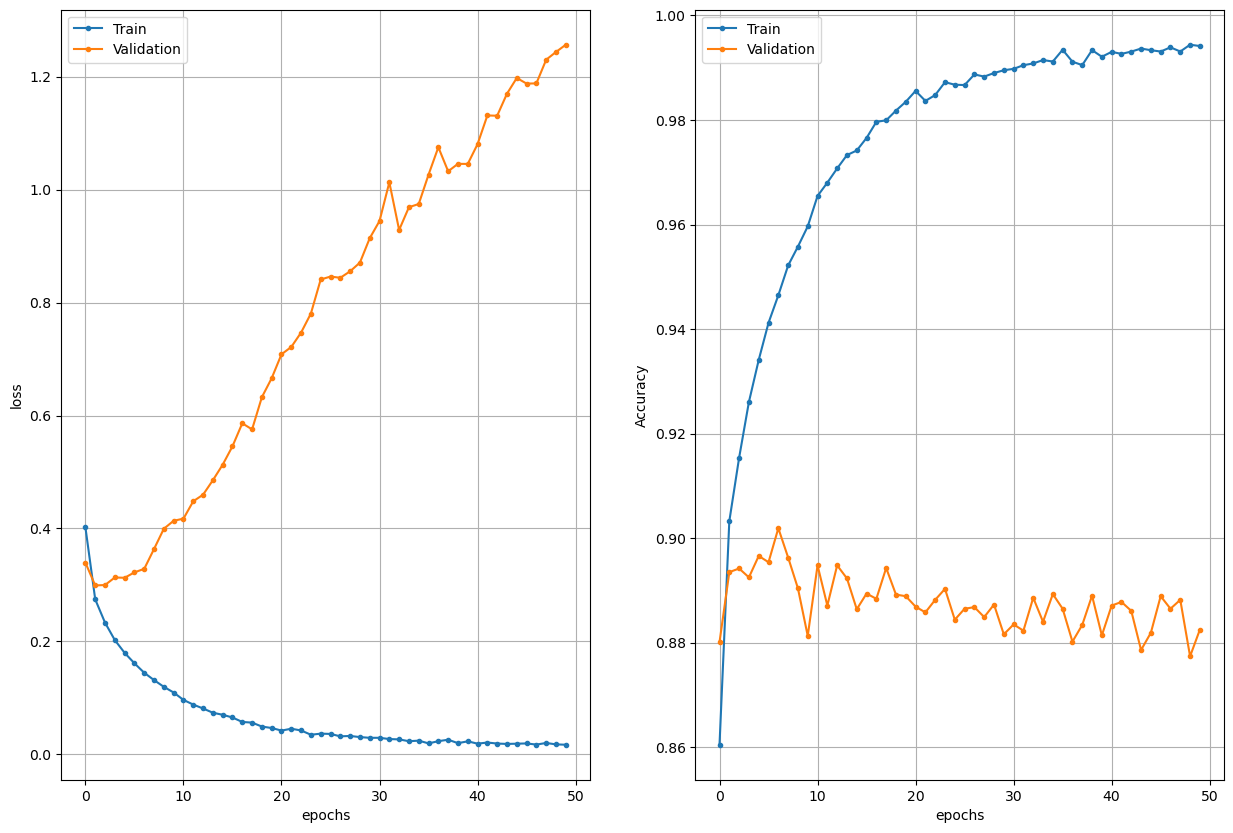

In [10]:
plot_history(history)

<h2>Combat with overfitting</h2>

In [40]:
# Modify the baseline classifier in order to reduce the overfitting and make the performance more robust

inputs = Input(shape=(28, 28, 1))
net = Conv2D(14, kernel_size=(3, 3), activation="relu", padding='same')(inputs)
net = Dropout(0.2)(net)
net = BatchNormalization()(net)
net = MaxPooling2D(pool_size=(2, 2))(net)
net = Conv2D(28, kernel_size=(3, 3), activation="relu", padding='same')(net)
net = Dropout(0.2)(net)
net = BatchNormalization()(net)
net = Flatten()(net)
net = Dense(64)(net)
net = Dropout(0.5)(net)
net = BatchNormalization()(net)
outputs = Dense(10, activation="softmax")(net)

model = Model(inputs, outputs)
model.summary()


Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_19 (Conv2D)          (None, 28, 28, 14)        140       
                                                                 
 dropout_6 (Dropout)         (None, 28, 28, 14)        0         
                                                                 
 batch_normalization_3 (Batc  (None, 28, 28, 14)       56        
 hNormalization)                                                 
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 14, 14, 14)       0         
 2D)                                                             
                                                                 
 conv2d_20 (Conv2D)          (None, 14, 14, 28)        355

In [26]:
from sklearn.utils import shuffle

def datagen(x, y, batch_size):
    num_samples = len(y)
    offsetMax = 1
    while True:
        for idx in range(0, num_samples, batch_size):
            x_ = x[idx:idx + batch_size, ...]
            y_ = y[idx:idx + batch_size]
            
            if len(y_) < batch_size:
                x, y = shuffle(x, y)
                break
            
            # Augmentation
            for idx_aug in range(batch_size):
                #Random flip
                #if np.random.rand() > 0.5:
                #    x_[idx_aug, ...] = np.fliplr(x_[idx_aug, ...])
                #Random color offset
                if np.random.rand() > 0.5:
                    img = x_[idx_aug, ...]
                    x_[idx_aug, ...] = x_[idx_aug, ...] * ( np.random.rand()*0.2 + 0.8) 
                    
                    
            yield x_, y_

In [41]:
epochs = 50
batch_size = 64
steps_per_epoch = len(y_train)/batch_size;
generator = datagen(x_train, y_train, batch_size)

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
start = time()
#history = model.fit(generator, steps_per_epoch=steps_per_epoch, epochs=epochs, validation_data=(x_test, y_test))
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test))
print('Elapsed time', time() - start)

Epoch 1/50
938/938 [==============================] - 23s 23ms/step - loss: 0.4521 - accuracy: 0.8460 - val_loss: 0.3316 - val_accuracy: 0.8789
Epoch 2/50
938/938 [==============================] - 21s 23ms/step - loss: 0.3257 - accuracy: 0.8850 - val_loss: 0.2965 - val_accuracy: 0.8952
Epoch 3/50
938/938 [==============================] - 22s 24ms/step - loss: 0.2907 - accuracy: 0.8978 - val_loss: 0.2816 - val_accuracy: 0.8994
Epoch 4/50
938/938 [==============================] - 22s 23ms/step - loss: 0.2716 - accuracy: 0.9036 - val_loss: 0.2574 - val_accuracy: 0.9088
Epoch 5/50
938/938 [==============================] - 23s 25ms/step - loss: 0.2569 - accuracy: 0.9083 - val_loss: 0.2545 - val_accuracy: 0.9079
Epoch 6/50
938/938 [==============================] - 23s 25ms/step - loss: 0.2479 - accuracy: 0.9121 - val_loss: 0.2473 - val_accuracy: 0.9106
Epoch 7/50
938/938 [==============================] - 22s 24ms/step - loss: 0.2400 - accuracy: 0.9139 - val_loss: 0.2477 - val_accuracy:

Train Acc      0.9425166845321655
Validation Acc 0.9196000099182129


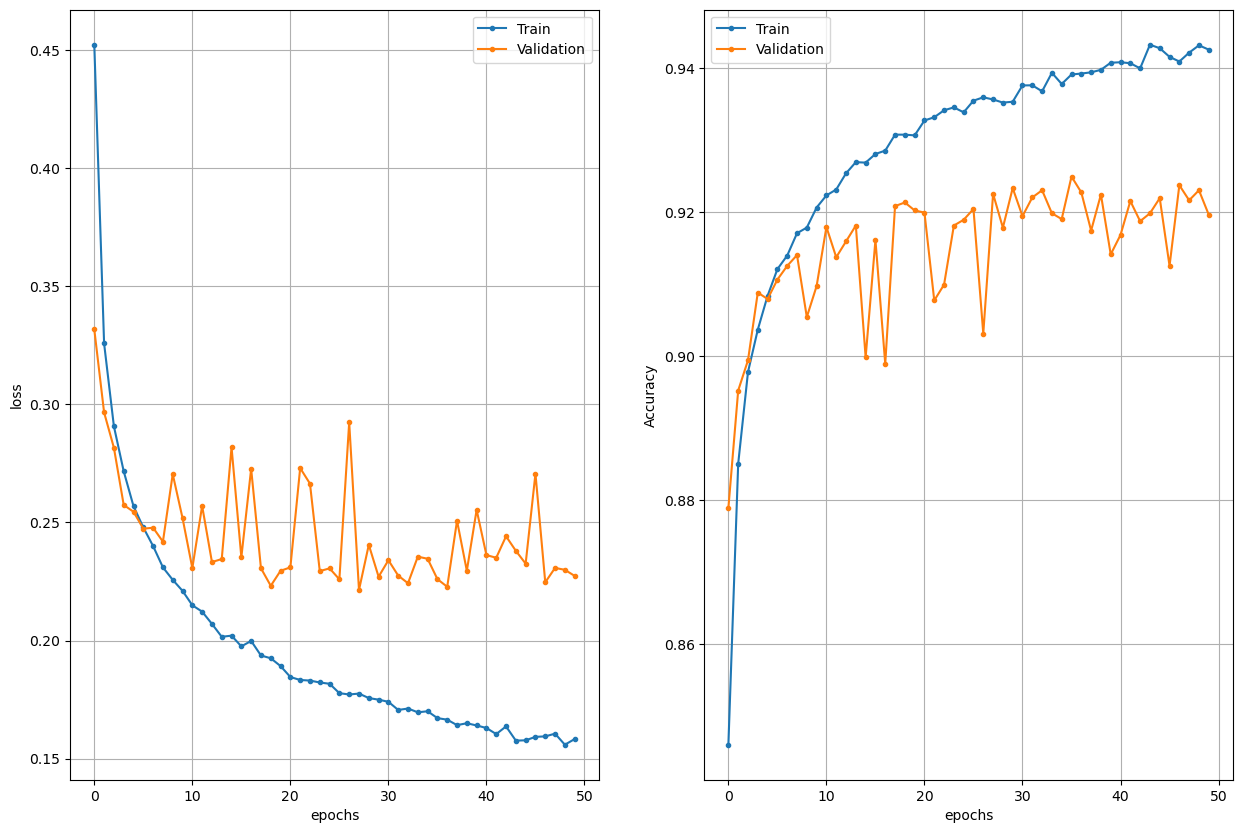

In [42]:
plot_history(history)


In [ ]:
                if np.random.rand() > 0.3:
                    img = x_[idx_aug, ...]
                    rows, cols = img.shape
                    offsetX = (np.random.rand() - 0.5)*offsetMax*2
                    offsetY = (np.random.rand() - 0.5)*offsetMax*2
                    M = np.float32([[1,0,offsetX],[0,1,offsetY]])
                    x_[idx_aug, ...] = cv2.warpAffine(img,M,(cols,rows)) 

<h2>Questions</h2>
<b>1.What have you done in order to improve the performance?</b><br>
<i>-simplfied network<br>
-added pooling<br>
-added dropout<br>
-added batch normalization</i><br>
<b>2.Have you tried configurations that did not work out?</b><br>
<i>Of course :D<br>
I tried data augmentations first such as: flip, affine transform, brightness.<br>
But it works terrible. This dataset have already nice and normilized data and good bounding boxes.<br>
I could predict it if inspected data carefully :D<br>
Also I've admit that all shoes oriented from right to left, so flipping was meaningless, and causes negative effect:D
</i>



<h2>Thanks for viewing!</h2> ❤️️